In [2]:
# %load C:\pointsgen\PointCloudGen-main\Diffusion-Model\diffusion model.py
"""
@Author: Alex
@Date: 2022.Dec.6th
Diffusion model
"""
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
import torch
import torch.nn as nn
import io
from PIL import Image

shape of s: (10000, 2)


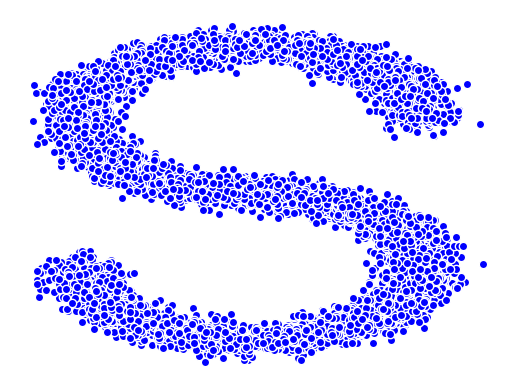

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)
# 生成一万个点，得到s curve
# sklearn package
s_curve,_ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0,2]]/10.0

print("shape of s:", np.shape(s_curve))

data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color='blue', edgecolor='white')
ax.axis('off')

#当成一个数据集
dataset = torch.Tensor(s_curve).float()
#画出 s curve
plt.show()

all the same shape torch.Size([100])


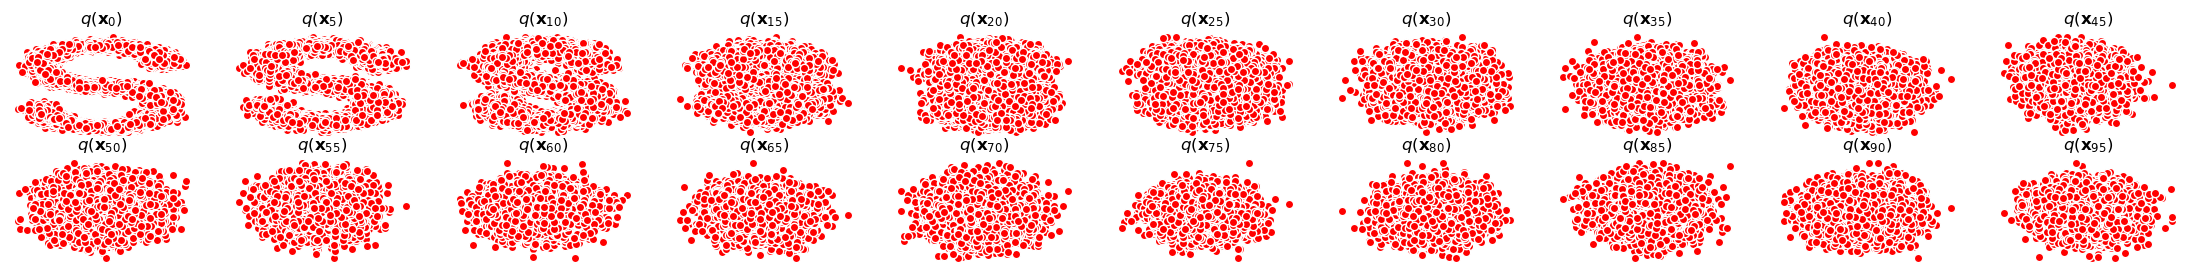

Training model...


In [11]:
#确定超参数的值
num_steps = 100  #可由beta值估算

#制定每一步的beta，beta按照时间从小到大变化
betas = torch.linspace(-6,6,num_steps).cuda()
betas = (torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5).cuda()

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas
# alpha连乘
alphas_prod = torch.cumprod(alphas,0)
#从第一项开始，第0项另乘1？？？
alphas_prod_p = torch.cat([torch.tensor([1]).float().cuda(), alphas_prod[:-1]],0)
# alphas_prod开根号
alphas_bar_sqrt = torch.sqrt(alphas_prod)
#之后公式中要用的
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
# 大小都一样，常数不需要训练
assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

# 给定初始，算出任意时刻采样值——正向扩散
# 计算任意时刻的x采样值，基于x_0和重参数化
def q_x(x_0, t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    #生成正态分布采样
    noise = torch.randn_like(x_0).cuda()
    #得到均值方差
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    #根据x0求xt
    return (alphas_t * x_0 + alphas_1_m_t * noise)  # 在x[0]的基础上添加噪声

# 演示加噪过程，加噪100步情况
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

# 共有10000个点，每个点包含两个坐标
# 生成100步以内每隔5步加噪声后的图像，扩散过程散点图演示——基于x0生成条件分布采样得到xt
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows]).cuda()) # 生成t时刻的采样数据
    axs[j,k].scatter(q_i[:,0].cpu(), q_i[:,1].cpu(), color='red', edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')
plt.show()


# 拟合逆扩散过程高斯分布模型——拟合逆扩散时的噪声


#自定义神经网络
class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t):
        #         x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)

        return x

#编写训练误差函数
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t，t变得随机分散一些，一个batch size里面覆盖更多的t
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps - 1 - t], dim=0)# t的形状（bz）
    t = t.unsqueeze(-1)# t的形状（bz,1）

    # x0的系数，根号下(alpha_bar_t)
    a = alphas_bar_sqrt[t]

    # eps的系数,根号下(1-alpha_bar_t)
    aml = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))

    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

#编写逆扩散采样函数

#从xt恢复x0
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq


def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x, t)
    #得到均值
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    #得到sample的分布
    sample = mean + sigma_t * z

    return (sample)

#开始训练模型，打印loss以及中间的重构效果
seed = 1234


class EMA():
    """构建一个参数平滑器"""

    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average


print('Training model...')
batch_size = 128
# dataset放到dataloader中
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# 迭代周期
num_epoch = 4000
plt.rc('text', color='blue')


In [15]:
#实例化模型，传入一个数
model = MLPDiffusion(num_steps)  # 输出维度是2，输入是x和step
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [16]:
for name, param in model.named_parameters():
    print(param.device, '', name, '', param.shape)


cuda:0  linears.0.weight  torch.Size([128, 2])
cuda:0  linears.0.bias  torch.Size([128])
cuda:0  linears.2.weight  torch.Size([128, 128])
cuda:0  linears.2.bias  torch.Size([128])
cuda:0  linears.4.weight  torch.Size([128, 128])
cuda:0  linears.4.bias  torch.Size([128])
cuda:0  linears.6.weight  torch.Size([2, 128])
cuda:0  linears.6.bias  torch.Size([2])
cuda:0  step_embeddings.0.weight  torch.Size([100, 128])
cuda:0  step_embeddings.1.weight  torch.Size([100, 128])
cuda:0  step_embeddings.2.weight  torch.Size([100, 128])


In [17]:
# epoch遍历
for t in range(num_epoch):
    # dataloader遍历
    for idx, batch_x in enumerate(dataloader):
        # 得到loss
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        #梯度clip，保持稳定性
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
    #每100步打印效果
    if (t % 100 == 0):
        print(loss)
        #根据参数采样一百个步骤的x，每隔十步画出来，迭代了4000个周期，逐渐更接近于原始
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white');
            axs[i - 1].set_axis_off();
            axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')
plt.show()

# 前向后向过程gif
imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off');

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)
plt.show()
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white', s=5);
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)
plt.show()
imgs = imgs +reverse
imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)